In [1]:
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(ggplot2))

In [2]:
seed <- 1234
set.seed(seed)

dataset <- "bortezomib"
sig_dir <- file.path("results", "singscore")

results_file <- file.path(sig_dir, paste0("singscore_results", dataset, ".tsv.gz"))

figure_dir <- file.path("figures", "singscore")

In [3]:
# Plotting options
legend_labels <- c(
    "training" = "Training",
    "test" = "Test",
    "validation" = "validation"
)

legend_colors <- c(
    "training" = "#DAC19A",
    "test" = "#8EB2B1",
    "validation" = "#9F95B9"
)

In [4]:
sig_cols <- readr::cols(
    .default = readr::col_character(),
    Metadata_clone_type_indicator = readr::col_integer(),
    Metadata_celltype_shorthand_from_plate_graph = readr::col_integer(),
    Metadata_date = readr::col_integer(),
    Metadata_treatment_shorthand_from_plate_graph = readr::col_integer(),
    TotalScore = readr::col_double(),
    TotalDispersion = readr::col_double(),
    UpScore = readr::col_double(),
    UpDispersion = readr::col_double(),
    DownScore = readr::col_double(),
    DownDispersion = readr::col_double(),
    Metadata_permuted_p_value = readr::col_double(),
    min_permuted_value = readr::col_double(),
    max_permuted_value = readr::col_double()
)

inference_df <- readr::read_tsv(results_file, col_types = sig_cols) %>%
    dplyr::filter(Metadata_model_split == "inference")
signature_df <- readr::read_tsv(results_file, col_types = sig_cols) %>%
    dplyr::filter(Metadata_model_split != "inference")

print(dim(signature_df))
head(signature_df, 4)

[1] 480  28


Metadata_Plate,Metadata_Well,Metadata_batch,Metadata_cell_count,Metadata_cell_density,Metadata_celltype_shorthand_from_plate_graph,Metadata_clone_number,Metadata_date,Metadata_plate_map_name,Metadata_time_to_adhere,⋯,TotalScore,TotalDispersion,UpScore,UpDispersion,DownScore,DownDispersion,Metadata_permuted_p_value,dataset,min_permuted_value,max_permuted_value
<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<chr>,<chr>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>
219907,B02,2021_03_03_Batch12,6139,2.5x10^3 cells/well,1,WT_parental,20210205,219814,48 hr,⋯,-0.79607503,538.1838,-0.48298838,0,-0.31308666,538.1838,1.000,bortezomib,-0.4643024,0.4651289
219907,B03,2021_03_03_Batch12,4567,2.5x10^3 cells/well,2,CloneA,20210205,219814,48 hr,⋯,-0.01820896,405.4911,0.08548341,0,-0.10369237,405.4911,0.528,bortezomib,-0.4643024,0.4651289
219907,B04,2021_03_03_Batch12,5624,2.5x10^3 cells/well,3,CloneE,20210205,219814,48 hr,⋯,0.03662240,298.7439,0.06762121,0,-0.03099881,298.7439,0.477,bortezomib,-0.4643024,0.4651289
219907,B05,2021_03_03_Batch12,5894,2.5x10^3 cells/well,4,WT clone 01,20210205,219814,48 hr,⋯,-0.04309095,329.1372,0.05344485,0,-0.09653581,329.1372,0.558,bortezomib,-0.4643024,0.4651289


In [5]:
table(signature_df$Metadata_model_split)


      test   training validation 
        84        336         60 

In [6]:
signature_df$Metadata_model_split <- factor(
    signature_df$Metadata_model_split, levels = c("training", "test", "validation")
)

min_val <- unique(signature_df$min_permuted_value)
max_val <- unique(signature_df$max_permuted_value)

Warning message:
“Duplicated aesthetics after name standardisation: size”

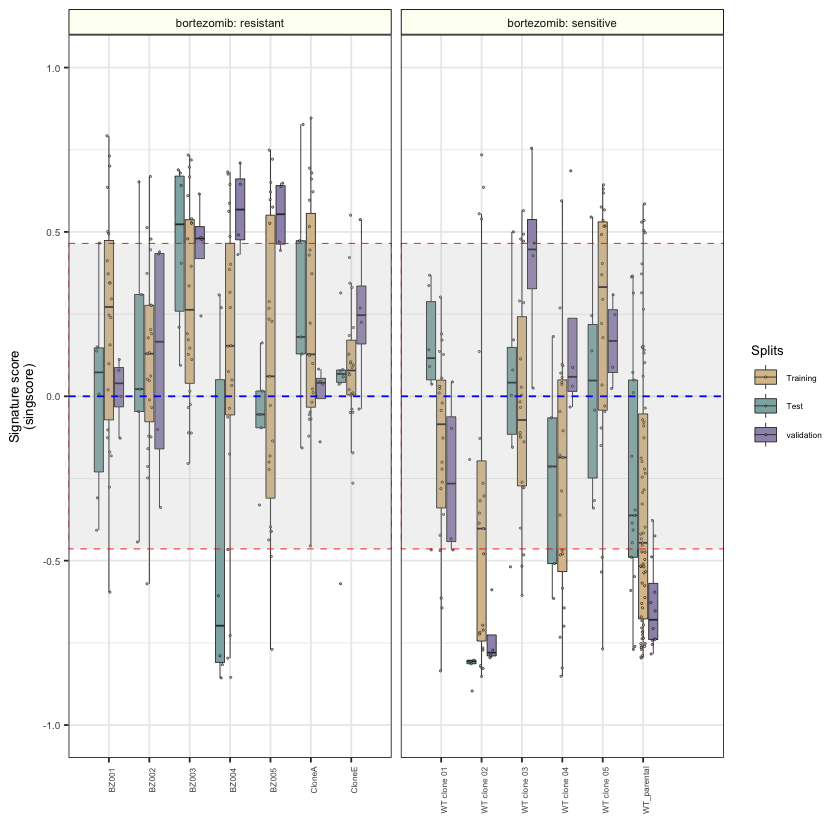

In [7]:
append_sig <- function(string) paste0(dataset, ": ", string)

result_gg <- (
    ggplot(signature_df,
           aes(x = Metadata_clone_number,
               y = TotalScore,
               group = paste(Metadata_clone_number, Metadata_model_split))) +
    geom_boxplot(aes(fill = Metadata_model_split), lwd = 0.25, outlier.alpha = 0) +
    geom_jitter(position = position_jitterdodge(jitter.width = 0.3, dodge.width = 0.75),
                aes(fill = Metadata_model_split),
                stroke = 0.2,
                size = 0.5,
                alpha = 0.8,
                shape = 21,
                lwd = 0.25) +
    facet_wrap("~Metadata_clone_type",
               ncol = 2,
               scales = "free_x",
               labeller = labeller(Metadata_clone_type = as_labeller(append_sig))) +
    xlab("") +
    ylab("Signature score\n(singscore)") +
    ylim(c(-1, 1)) +
    scale_fill_manual("Splits", values = legend_colors, labels = legend_labels) +
    theme_bw() +
    theme(
        legend.title = element_text(size = 8),
        legend.text = element_text(size = 5),
        axis.title = element_text(size = 8),
        axis.text.y = element_text(size = 6),
        axis.text.x = element_text(angle = 90, size = 5),
        strip.text = element_text(size = 7),
        strip.background = element_rect(colour="black", fill="#fdfff4")
    ) +
    annotate(
        "rect",
         ymin = min_val,
         ymax = max_val,
         xmin = 0,
         xmax = ceiling(length(unique(signature_df$Metadata_clone_number)) / 2) + 1,
         alpha = 0.2,
         color = "red",
         linetype = "dashed",
         fill = "grey",
         lwd = 0.25
    ) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "blue")
)

output_fig_file <- file.path("figures", "signature_scores_training_testing_validation.png")
ggsave(output_fig_file, result_gg, dpi = 500, height = 3, width = 5)

result_gg

Warning message:
“Duplicated aesthetics after name standardisation: size”

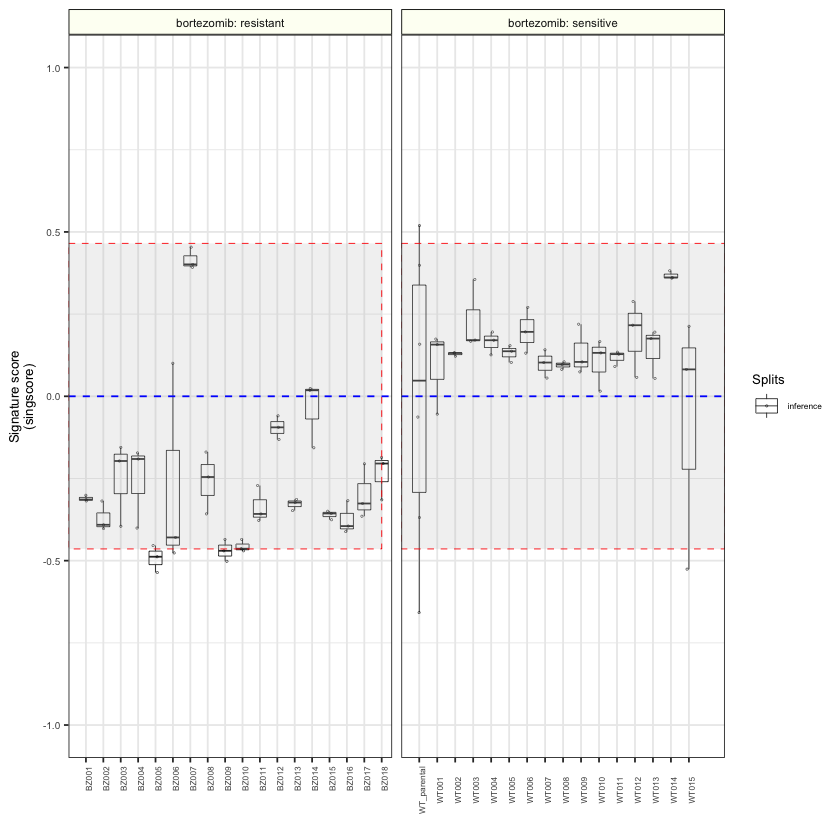

In [8]:
inference_gg <- ggplot(inference_df,
           aes(x = Metadata_clone_number,
               y = TotalScore,
               group = paste(Metadata_clone_number, Metadata_model_split))) +
    geom_boxplot(aes(fill = Metadata_model_split), lwd = 0.25, outlier.alpha = 0) +
    geom_jitter(position = position_jitterdodge(jitter.width = 0.3, dodge.width = 0.75),
                aes(fill = Metadata_model_split),
                stroke = 0.2,
                size = 0.5,
                alpha = 0.8,
                shape = 21,
                lwd = 0.25) +
    facet_wrap("~Metadata_clone_type",
               ncol = 2,
               scales = "free_x",
               labeller = labeller(Metadata_clone_type = as_labeller(append_sig))) +
    xlab("") +
    ylab("Signature score\n(singscore)") +
    ylim(c(-1, 1)) +
    scale_fill_manual("Splits", values = legend_colors, labels = legend_labels) +
    theme_bw() +
    theme(
        legend.title = element_text(size = 8),
        legend.text = element_text(size = 5),
        axis.title = element_text(size = 8),
        axis.text.y = element_text(size = 6),
        axis.text.x = element_text(angle = 90, size = 5),
        strip.text = element_text(size = 7),
        strip.background = element_rect(colour="black", fill="#fdfff4")
    ) +
    annotate(
        "rect",
         ymin = min_val,
         ymax = max_val,
         xmin = 0,
         xmax = ceiling(length(unique(inference_df$Metadata_clone_number)) / 2) + 1,
         alpha = 0.2,
         color = "red",
         linetype = "dashed",
         fill = "grey",
         lwd = 0.25
    ) +
    geom_hline(yintercept = 0, linetype = "dashed", color = "blue")

output_fig_file <- file.path("figures", "signature_scores_inference.png")
ggsave(output_fig_file, inference_gg, dpi = 500, height = 3, width = 5)

inference_gg

In [9]:
perf_dir <- file.path("results", "performance")

metric_levels <- c("total", "plate", "sample")
shuffle_levels <- c("", "shuffle")

performance_data <- list()
for (metric_level in metric_levels) {
    performance_data[[metric_level]] <- list()
    for (shuffle_level in shuffle_levels) {
        if (shuffle_level == "shuffle") {
            shuffle_id <- "_shuffle"
        } else {
            shuffle_id <- ""
        }
        
        input_file <- paste0(metric_level, "_bortezomib", shuffle_id, "_metric_performance.tsv")
        input_file <- file.path(perf_dir, input_file)
        performance_data[[metric_level]][[shuffle_level]] <-
            readr::read_tsv(input_file, col_types = readr::cols())
    }
}

In [10]:
metric_compare <- "total"
split_order <- c("training", "test", "validation", "inference")

plot_df <- performance_data[[metric_compare]][[1]]
shuff_df <- performance_data[[metric_compare]][["shuffle"]]

plot_df$Metadata_model_split <- factor(
    plot_df$Metadata_model_split,
    levels = split_order
)

shuff_df$Metadata_model_split <- factor(
    shuff_df$Metadata_model_split,
    levels = split_order
)

In [11]:
total_performance_gg <- (
    ggplot(plot_df, aes(x = metric, y = metric_value)) +
    geom_bar(
        aes(fill = dataset),
        color = "black",
        stat = "identity",
        position = "dodge",
        lwd = 0.3
    ) +
    geom_boxplot(
        data = shuff_df,
        aes(fill = dataset),
        position = position_dodge(width = 0.9),
        outlier.alpha = 0,
        lwd = 0.2
    ) +
    geom_jitter(
        data = shuff_df,
        position = position_jitterdodge(jitter.width = 0.4, dodge.width = 0.9),
        aes(fill = dataset),
        size = 0.4,
        alpha = 0.5,
        shape = 21,
        stroke = 0.2
    ) +
    facet_wrap("~Metadata_model_split") +
    xlab("") +
    ylab("Performance") +
    theme_bw() +
    theme(
        legend.title = element_text(size = 8),
        legend.text = element_text(size = 5),
        legend.key.size = unit(0.4, "cm"),
        axis.title = element_text(size = 8),
        axis.text = element_text(size = 6),
        strip.text = element_text(size = 7),
        strip.background = element_rect(colour="black", fill="#fdfff4")
    )
)

output_fig_file <- file.path("figures", "total_performance.png")
ggsave(output_fig_file, total_performance_gg, dpi = 500, height = 4.2, width = 4)

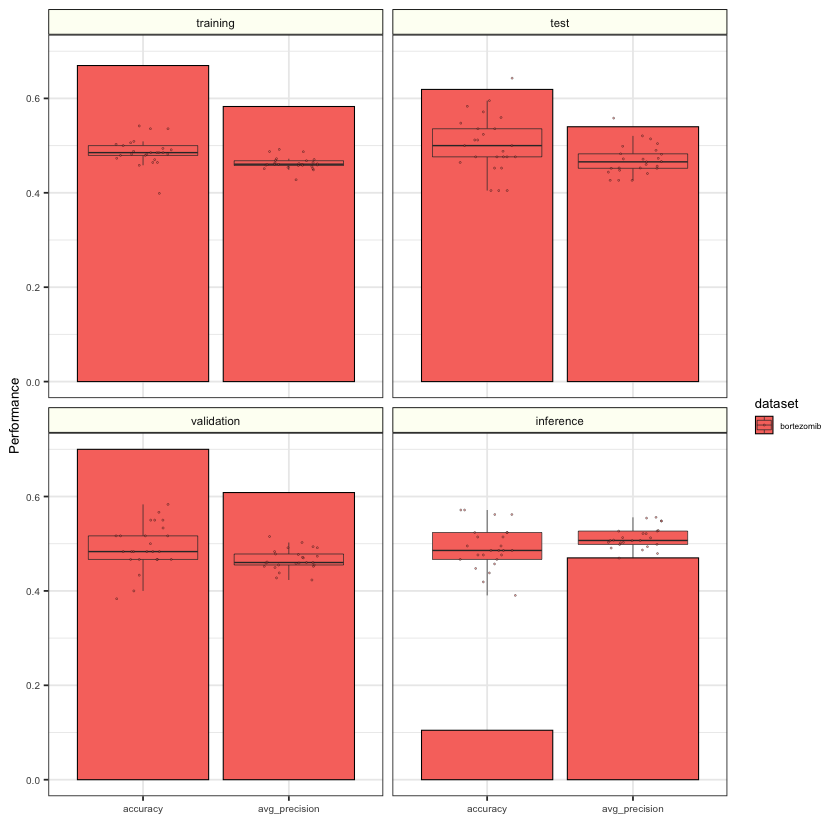

In [12]:
total_performance_gg